In [1]:
%load_ext memory_profiler

import glob
import h5py
import numpy as np
import pandas as pd
import dask.array as da
import dask.dataframe as dd
import dask_ml.decomposition
import matplotlib.pyplot as plt

from sklearn import decomposition
from sklearn import datasets

# peak memory vs increment
# https://stackoverflow.com/questions/45318536/trying-to-understand-python-memory-profiler



In [2]:
TCGA_FILENAMES = glob.glob('data/TCGA-*[!metas].csv')

In [3]:
def do_transform_pandas_csv():
    df = pd.concat(map(pd.read_csv, TCGA_FILENAMES))
    X = df.to_numpy()
    X = np.log2(X + 1)
    pca = decomposition.PCA(n_components=2)
    pca.fit(X)
    return pca.transform(X)

%time %memit X_transformed = do_transform_pandas_csv()

peak memory: 10219.20 MiB, increment: 10004.44 MiB
CPU times: user 6min, sys: 20.3 s, total: 6min 20s
Wall time: 5min 6s


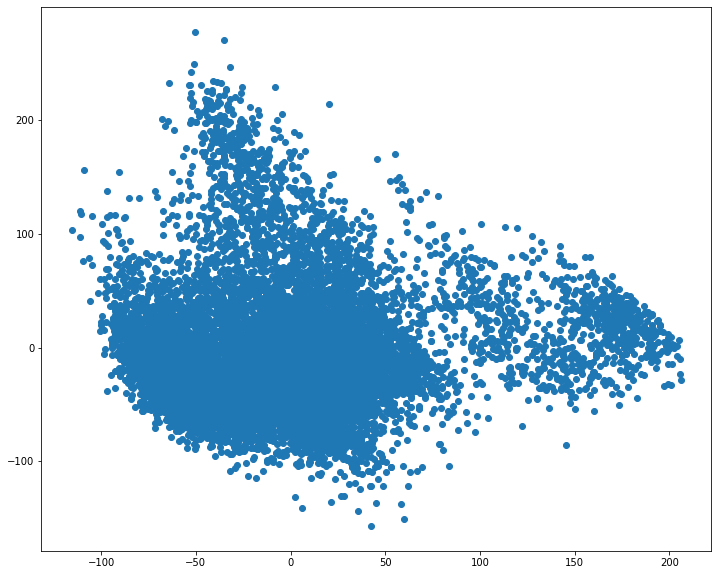

In [4]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12, 10))
plt.scatter(x=X_transformed[:, 0], y=X_transformed[:, 1])

In [5]:
def do_transform():
    X = h5py.File('data/tcga_all.h5')['X'][()]
    X = np.log2(X + 1)
    pca = decomposition.PCA(n_components=2)
    pca.fit(X)
    return pca.transform(X)

%time %memit X_transformed = do_transform()

peak memory: 10404.83 MiB, increment: 10055.91 MiB
CPU times: user 1min 31s, sys: 12.7 s, total: 1min 44s
Wall time: 25.2 s


In [6]:

X = da.from_array(h5py.File('data/tcga_all.h5')['X'])
X = np.log2(X + 1)
pca = dask_ml.decomposition.IncrementalPCA(n_components=2)
pca.fit(X)
X_transformed = pca.transform(X)
%time %memit X_transformed = X_transformed.compute()


/Users/jakakokosar/.pyenv/versions/3.9.9/envs/orange/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


peak memory: 2372.25 MiB, increment: 30.22 MiB
CPU times: user 19.9 s, sys: 30 s, total: 49.9 s
Wall time: 8.53 s


peak memory: 4458.95 MiB, increment: 2085.81 MiB
CPU times: user 3.42 s, sys: 4.42 s, total: 7.84 s
Wall time: 11.1 s


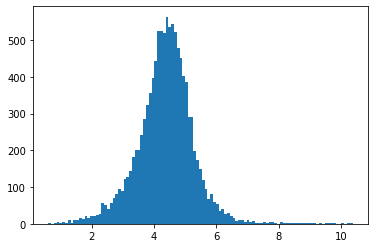

In [7]:
def get_exp_values():
    X = h5py.File('data/tcga_all.h5')['X'][()]
    X = np.log2(X + 1)
    return X[:, 6785]

%time %memit KRAS_expression_values = get_exp_values()

_ = plt.hist(KRAS_expression_values, bins='auto')


peak memory: 1034.98 MiB, increment: 333.83 MiB
CPU times: user 276 ms, sys: 307 ms, total: 583 ms
Wall time: 1.97 s


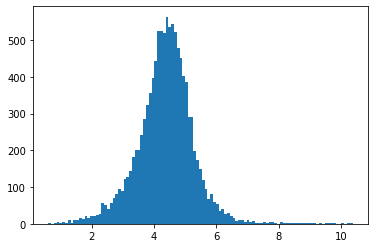

In [8]:
X = da.from_array(h5py.File('data/tcga_all.h5')['X'])
X = np.log2(X + 1)
exp = X[:, 6785]
%time %memit exp = exp.compute()

_ = plt.hist(exp, bins='auto')